In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel; print(allel.__version__)
%aimport allel.stats.selection

0.21.1.dev1


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [4]:
n_variants = 500000
n_samples = 100

h = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, :n_samples]).to_haplotypes()
h

,0,1,2,3,4,...,195,196,197,198,199
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [5]:
pos = callset['3R']['variants/POS'][:n_variants]
pos

array([   1252,    1262,    1271, ..., 1927216, 1927221, 1927229], dtype=int32)

In [6]:
ac = h.count_alleles(max_allele=1)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h_seg = h.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

106315

In [7]:
%%time
score_0min = allel.stats.ihs(h_seg, pos_seg, min_ehh=0, min_maf=0, include_edges=True, use_threads=False)

CPU times: user 24.6 s, sys: 4 ms, total: 24.6 s
Wall time: 24.6 s


In [8]:
%%time
score = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, min_maf=0, include_edges=True, use_threads=False)

CPU times: user 18.9 s, sys: 0 ns, total: 18.9 s
Wall time: 18.9 s


In [9]:
%%time
score_threaded = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, min_maf=0, include_edges=True, use_threads=True)

CPU times: user 20 s, sys: 8 ms, total: 20 s
Wall time: 10 s


In [10]:
score_0min

array([ 2.46996202,  3.58837555,  0.21571052, ..., -0.06716014,
        1.24880654,  1.72846939])

In [11]:
score

array([ 2.951916  ,  4.05147157,  0.68644474, ...,  0.09473252,
        1.13704333,  1.48152227])

In [12]:
score_threaded

array([ 2.951916  ,  4.05147157,  0.68644474, ...,  0.09473252,
        1.13704333,  1.48152227])

In [13]:
cProfile.run('allel.stats.ihs(h_seg[:50000], pos_seg[:50000], min_ehh=0.05, min_maf=0, include_edges=True, use_threads=False)', sort='time')

         135 function calls in 9.486 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    9.481    4.740    9.481    4.741 stats.pyx:708(ihh01_scan_int8)
        1    0.004    0.004    9.486    9.486 selection.py:326(ihs)
        1    0.000    0.000    0.001    0.001 selection.py:256(compute_ihh_gaps)
        2    0.000    0.000    0.000    0.000 function_base.py:1518(diff)
        1    0.000    0.000    9.486    9.486 {built-in method builtins.exec}
        9    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
        1    0.000    0.000    9.486    9.486 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.copyto}
        1    0.000    0.000    0.000    0.000 {method 'astype' of 'numpy.ndarray' objects}
        4    0.000    0.000    0.000    0.000 stringsource:985(memoryview_fromslice)
        5    0.000    0.000    0.000    0.000 

In [14]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(0, 106315)

In [15]:
np.count_nonzero(np.isinf(score)), np.count_nonzero(~np.isinf(score))

(0, 106315)

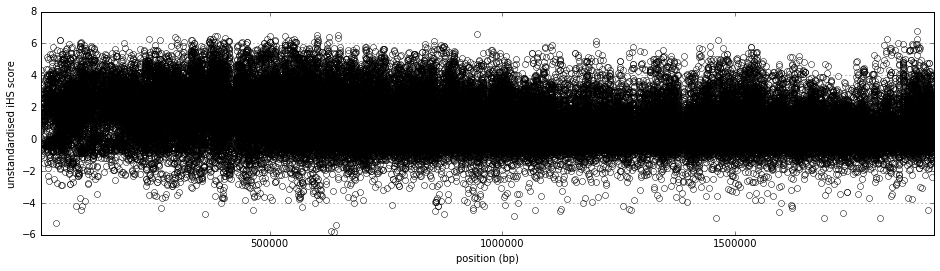

In [16]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised iHS score')
plt.autoscale(axis='x', tight=True);

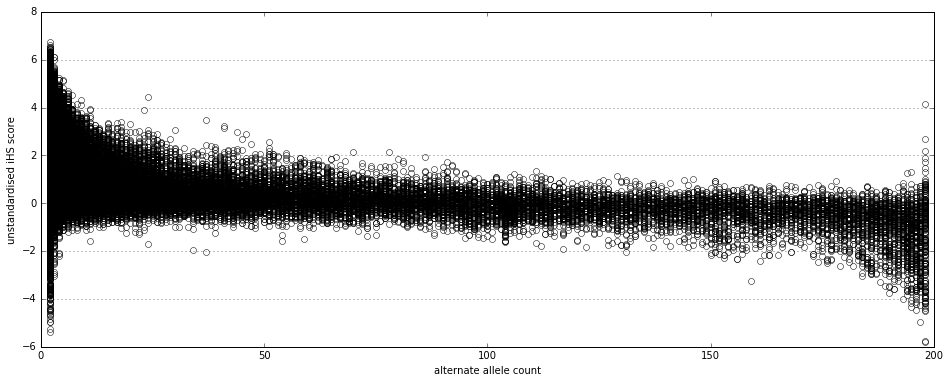

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('unstandardised iHS score')
plt.grid(axis='y');

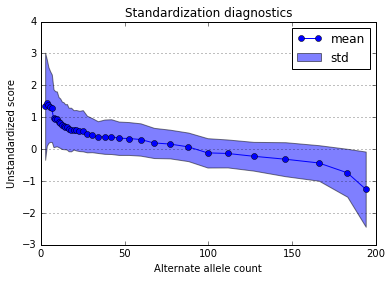

In [19]:
score_standardized, ac_bins = allel.stats.standardize_by_allele_count(score, ac_seg[:, 1])

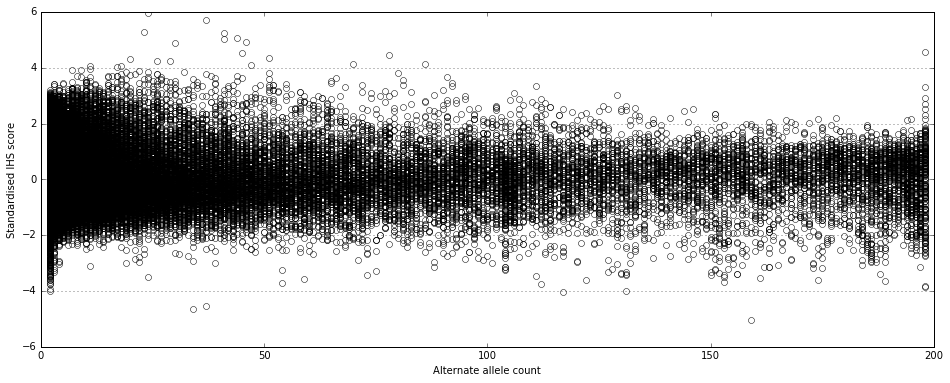

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score_standardized, linestyle=' ', marker='o', mfc='none')
plt.xlabel('Alternate allele count')
plt.ylabel('Standardised IHS score')
plt.grid(axis='y');

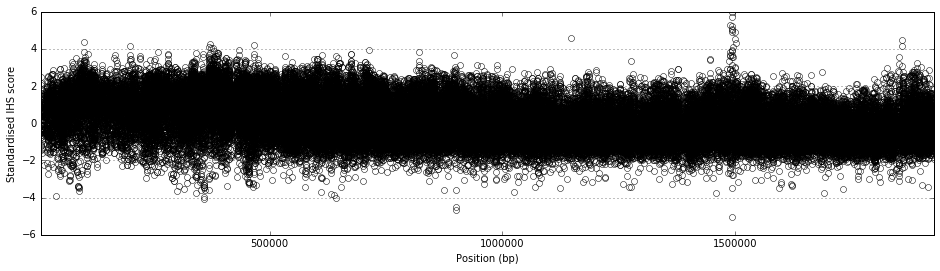

In [21]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_standardized, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('Position (bp)')
plt.ylabel('Standardised IHS score')
plt.autoscale(axis='x', tight=True);

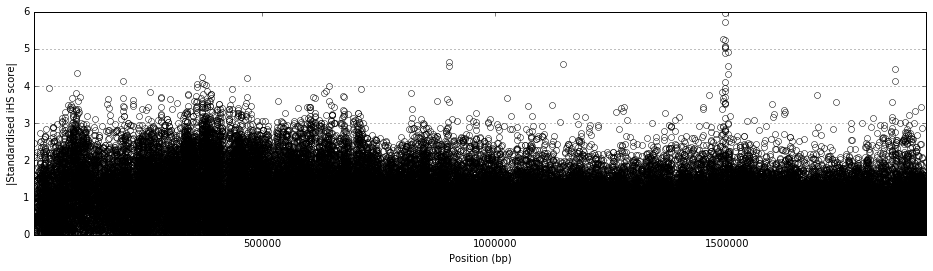

In [22]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, np.abs(score_standardized), linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('Position (bp)')
plt.ylabel('|Standardised iHS score|')
plt.autoscale(axis='x', tight=True);

In [23]:
h_seg.shape

(106315, 200)

## Gap handling

In [61]:
loc_variants = slice(4000000, 9000000, 1)
n_samples = 50

h = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, :n_samples]).to_haplotypes()
h

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [62]:
pos = callset['3R']['variants/POS'][loc_variants]
pos

array([16532852, 16532853, 16532854, ..., 42555205, 42555210, 42555213], dtype=int32)

In [63]:
ac = h.count_alleles(max_allele=1)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 5)
h_seg = h.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

342352

In [64]:
def plot_score_gap(score, pos, ylim=(-12, 12)):

    fig = plt.figure(figsize=(16, 4))

    ax = fig.add_subplot(111)
    ax.plot(pos, score, linestyle=' ', marker='o', mfc='none', markersize=2)
    ax.grid(axis='y')
    ax.set_xlabel('position (bp)')
    ax.set_ylabel('score')
    ax.set_ylim(*ylim)

    ax = ax.twinx()
    x = (pos[:-1] + pos[1:]) / 2
    y = np.diff(pos)
    ax.plot(x, y)
    ax.set_ylabel('gap size (bp)')
    ax.autoscale(axis='x', tight=True);

In [65]:
accessibility = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/accessibility/accessibility.h5', mode='r')
is_accessible = accessibility['3R']['is_accessible'][:]
is_accessible

array([False, False, False, ..., False, False, False], dtype=bool)

In [76]:
%%time
score_unadjusted = allel.stats.ihs(h_seg, pos_seg, include_edges=True, max_gap=None, gap_scale=None)

CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 8.64 s


In [77]:
np.count_nonzero(np.isnan(score_unadjusted)), np.count_nonzero(~np.isnan(score_unadjusted)) 

(0, 342352)

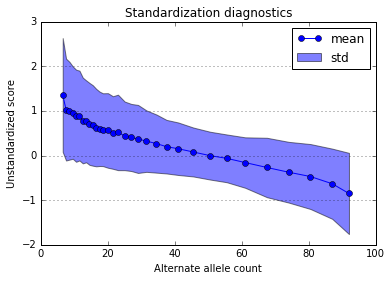

In [78]:
score_unadjusted, _ = allel.stats.standardize_by_allele_count(score_unadjusted, ac_seg[:, 1])

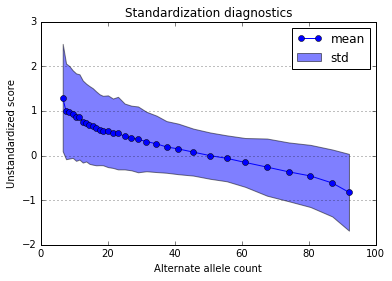

In [79]:
score_gap_adjusted = allel.stats.ihs(h_seg, pos_seg, max_gap=200000, gap_scale=1000)
score_gap_adjusted, _ = allel.stats.standardize_by_allele_count(score_gap_adjusted, ac_seg[:, 1])

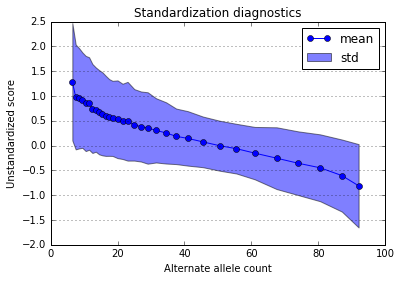

In [80]:
score_access_adjusted = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, max_gap=None, gap_scale=None, 
                                        is_accessible=is_accessible)
score_access_adjusted, _ = allel.stats.standardize_by_allele_count(score_access_adjusted, ac_seg[:, 1])

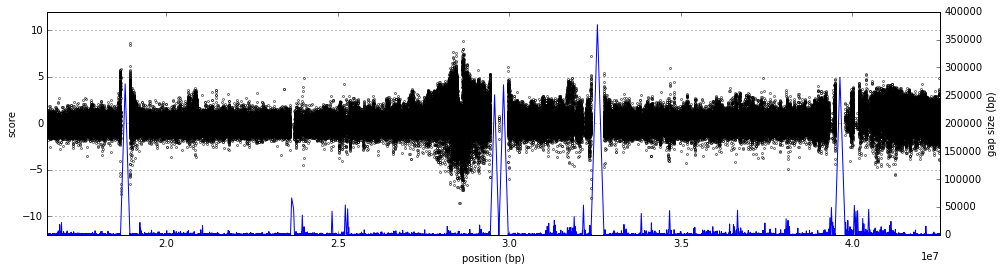

In [81]:
plot_score_gap(score_unadjusted, pos_seg)

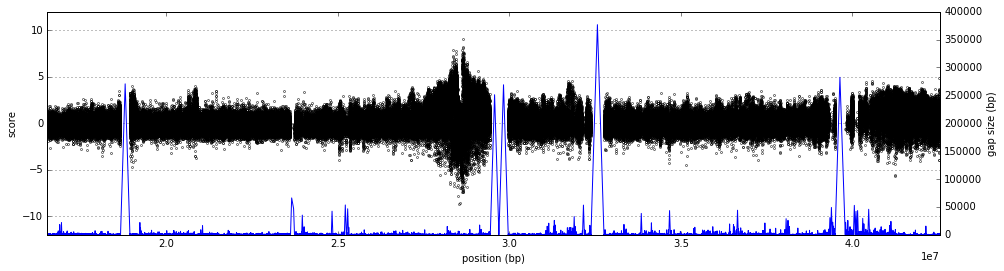

In [82]:
plot_score_gap(score_gap_adjusted, pos_seg)

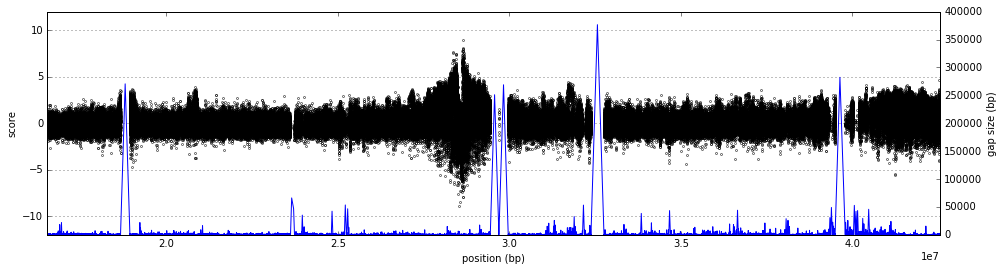

In [83]:
plot_score_gap(score_access_adjusted, pos_seg)

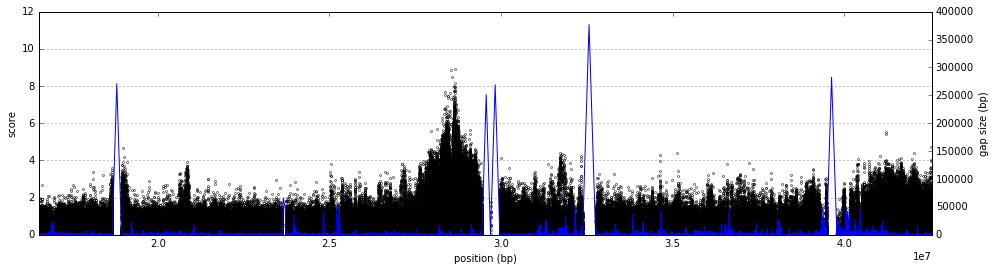

In [84]:
plot_score_gap(np.abs(score_access_adjusted), pos_seg, ylim=(0, 12))

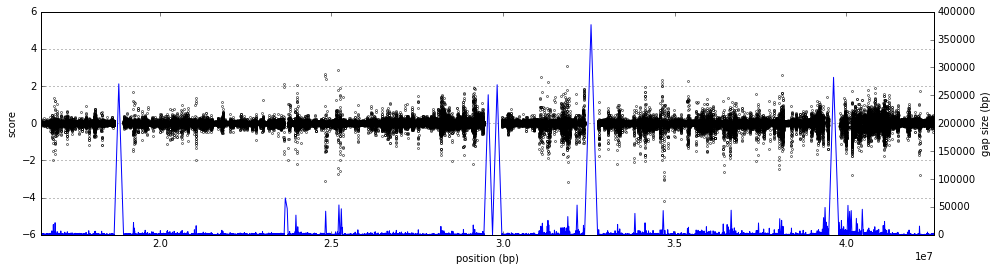

In [85]:
plot_score_gap(score_gap_adjusted - score_unadjusted, pos_seg, ylim=(-6, 6))

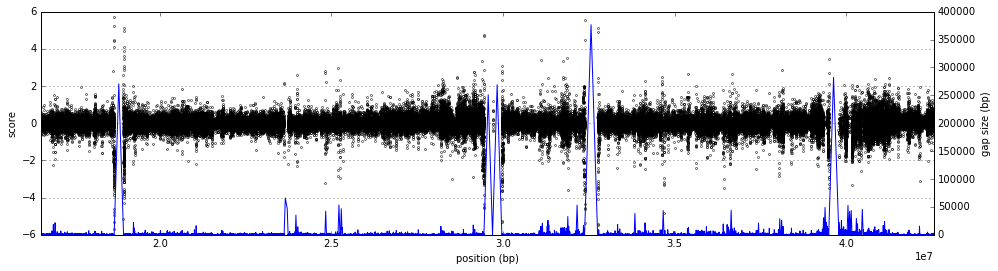

In [86]:
plot_score_gap(score_access_adjusted - score_unadjusted, pos_seg, ylim=(-6, 6))

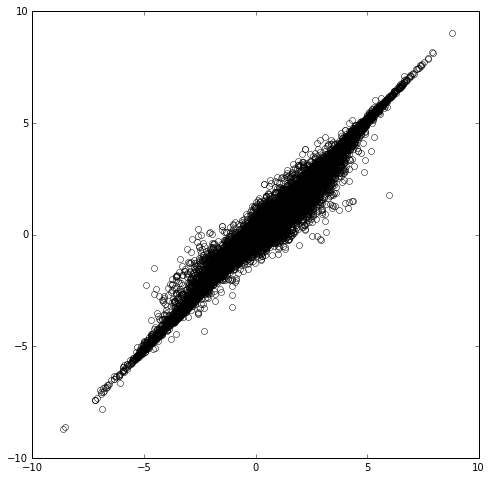

In [87]:
plt.figure(figsize=(8, 8))
plt.plot(score_unadjusted, score_gap_adjusted, marker='o', mfc='none', linestyle=' ');

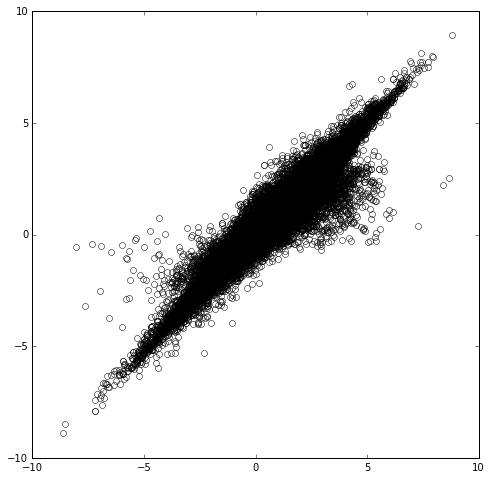

In [88]:
plt.figure(figsize=(8, 8))
plt.plot(score_unadjusted, score_access_adjusted, marker='o', mfc='none', linestyle=' ');

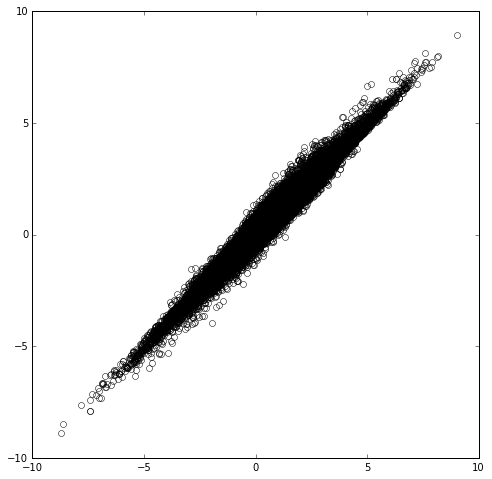

In [89]:
plt.figure(figsize=(8, 8))
plt.plot(score_gap_adjusted, score_access_adjusted, marker='o', mfc='none', linestyle=' ');

## Min MAF

In [90]:
loc_variants = slice(4000000, 9000000, 1)
n_samples = 50

h = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, :n_samples]).to_haplotypes()
h

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [97]:
pos = callset['3R']['variants/POS'][loc_variants]
pos

array([16532852, 16532853, 16532854, ..., 42555205, 42555210, 42555213], dtype=int32)

In [98]:
ac = h.count_alleles(max_allele=1)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 0)
h_seg = h.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

1665623

In [99]:
%%time
score = allel.stats.ihs(h_seg, pos_seg, min_maf=0.05, max_gap=200000, gap_scale=1000)

CPU times: user 1min, sys: 12 ms, total: 1min
Wall time: 30.3 s


In [100]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(1271853, 393770)

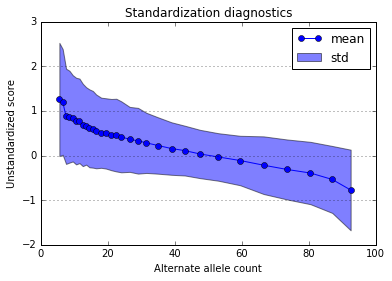

In [101]:
score_std, _ = allel.stats.standardize_by_allele_count(score, ac_seg[:, 1])

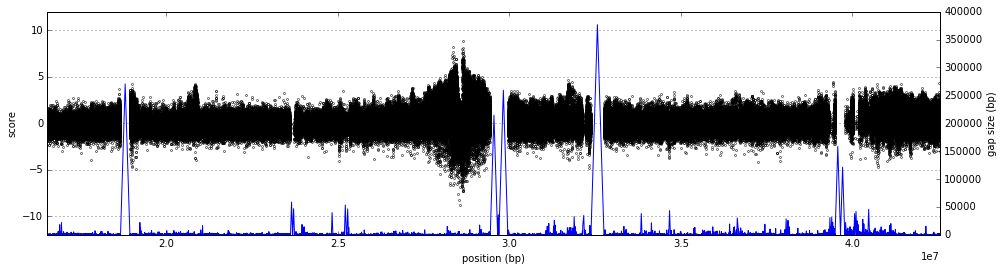

In [102]:
plot_score_gap(score_std, pos_seg)

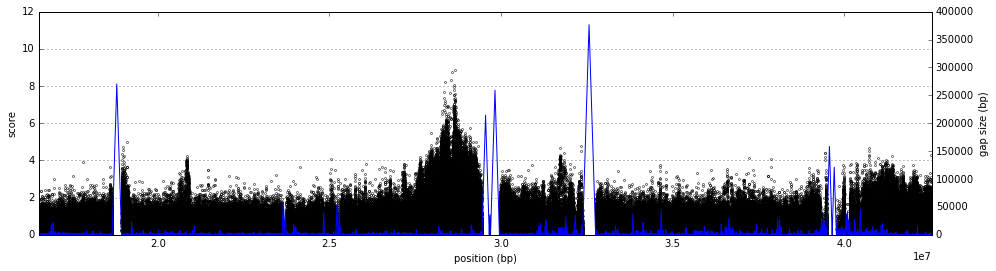

In [103]:
plot_score_gap(np.abs(score_std), pos_seg, ylim=(0, 12))